In [1]:
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, Lambda, RepeatVector, Reshape, Activation
from keras.optimizers import Adam
from keras.models import Model
from keras.layers.merge import Dot
from keras import backend as K
from keras.utils import to_categorical
from keras.initializers import RandomNormal, glorot_uniform

import numpy as np
import utils
import random
import tensorflow as tf
from itertools import combinations

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=2,\
        inter_op_parallelism_threads=2, allow_soft_placement=True,\
        device_count = {'CPU' : 1, 'GPU' : 0})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = utils.load_data('cora')
features_d = features.toarray()  # 2708 nodes each with 1433 dimensions
adj_d = adj.toarray()
X_train, X_val, X_test = features_d[train_mask], features_d[val_mask], features_d[test_mask]
Y_train, Y_val, Y_test = y_train[train_mask], y_val[val_mask], y_test[test_mask]  # One-got encoded

Y_train_class_numbers = np.argmax(Y_train, axis=1)  # Instead of one-hot encoding, we have list of class numbers for labels
train_nodes_position, val_nodes_position, test_nodes_position = np.where(train_mask)[0], np.where(val_mask)[0], np.where(test_mask)[0]

In [4]:
def random_walk(sample_size):
    """
    Returns a list of nodes of sample_size
    """
    S1 = np.random.randint(0, adj.shape[0])
    nodes = [S1]

    sample_size -= 1 # Since we add S1 node at the start
    Si = S1
    for _ in range(sample_size):
        row = adj_d[Si]
        row_p = row / np.sum(row)
        # Randomy choose the index (node) based on probability distribution
        Sj = np.random.choice(np.arange(len(row)), size=None, p=row_p)
        nodes.append(Sj)
        Si = Sj
    return nodes

In [5]:
# ALGORITHM 1
def sample_context(r1=0.83, r2=0.5, q=10, d=3):
    """
    r1 = Corruption prob. Default = 0.83
    r2 = Some. prob
    q =  Random walk length
    d =  Window length - Number of hops between two nodes in random walk
    """
    i = None
    c = None
    gamma = None

    if np.random.random_sample() < r1:
        gamma = 1
    else:
        gamma = -1

    if np.random.random_sample() < r2:
        rand_walk = random_walk(q)

        comb = list(combinations(range(len(rand_walk)), 2))
        context_choices = list(filter(lambda x: abs(x[1] - x[0]) < d, comb))
        
        i_index, c_index = random.choice(context_choices)
        
        i, c = rand_walk[i_index], rand_walk[c_index]
        
        if gamma == -1:
            c = np.random.randint(0, adj.shape[0])
    else:
        if gamma == 1:
            i = np.random.choice(train_nodes_position)
            context_choices = np.where(Y_train_class_numbers == Y_train_class_numbers[i])[0]
            c = np.random.choice(context_choices)
        else:
            i = np.random.choice(train_nodes_position)
            context_choices = np.where(Y_train_class_numbers != Y_train_class_numbers[i])[0]
            c = np.random.choice(context_choices)
    return i, c, gamma

In [6]:
def custom_loss(y_true, y_pred):
    """
    y_true is a vector/Tensor or gamma values (column vector of shape ? x 1) and y_pred is dot(w_c, e_i).
    Return: Tensor with shape (?,): A 1D Tensor
    """
    
    l = y_true * y_pred
    loss = -K.log(K.sigmoid(l))
    loss = K.squeeze(loss, axis=1)
    return loss

In [7]:
def create_models():

    emb_size = 50

    # inputs
    i_inputs = Input(shape=(1, ))
    e_i = Embedding(adj.shape[0]+1, emb_size)(i_inputs) # output shape (?, 1, emb_size)

    # context
    c_inputs = Input(shape=(1, ))
    w_c  = Embedding(adj.shape[0]+1, emb_size)(c_inputs)

    # output
    o = Dot(axes=2)([w_c, e_i])
    o = Reshape((1,), input_shape=(1, 1))(o)

    o = Activation('sigmoid')(o)
    SkipGram = Model(inputs=[i_inputs, c_inputs], outputs=o)

    # SkipGram.compile(loss=custom_loss, optimizer='adam', metrics=['accuracy'])
    SkipGram.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    h1_f_units = 128 # y_train.shape[1]
    h1_e_units = 128 # y_train.shape[1]


    inp_features = Input(shape=(X_train.shape[1],))
    h1_features = Dense(h1_f_units, activation='relu')(inp_features)

    node_flatten = Flatten()(e_i)
    h1_emb = Dense(h1_e_units, activation='relu')(node_flatten)


    c = Concatenate()([h1_features, h1_emb])
    out_label = Dense(y_train.shape[1], activation='softmax')(c)

    model_label = Model(inputs=[inp_features, i_inputs], outputs=out_label)
    model_label.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return SkipGram, model_label

In [10]:
from datetime import datetime

In [23]:
# %%timeit -n 1 -r 3

# ALGORITHM 2
# Since we also need to feed embedding layer with node number information, need to manually write training code

# SIMIALR TO GCN, WE CANNOT USE GLOBAL ACCURACY/LOSS INFORMATION SINCE WE DO NOT HAVE GROUND TRUTH FOR MOST OF THE INPUT DATA
# WE CAN ONLY MEASURE ACCURACY/LOSS FOR THE TEST INDICES OF THE DATASET

TOTALRUNS = 4
SkipGram, model_label = create_models()

T1 = 50  # Number of batch iterations
N1 = 128 # Batch size

T2 = 50
N2 = 128

count = 0

start = datetime.now()

for _ in range(TOTALRUNS):
    
    count += 1
    print(count)
    
    for _ in range(T1):
        # replace=False means can't sample sample point twice
        train_sample_indices = np.random.choice(np.arange(len(Y_train)), size=N1, replace=True)
        nodes_in_batch = train_nodes_position[train_sample_indices]

        train_features = features_d[nodes_in_batch]
        train_labels = Y_train[train_sample_indices]
        node_numbers = nodes_in_batch[:, np.newaxis]
        
        # We use batch_size=N1 so that we only take a gradient step after using batch_size values
        hist = model_label.fit([train_features, node_numbers], train_labels, batch_size=N1, 
                        validation_data=([features_d[val_nodes_position], val_nodes_position], Y_val), verbose=0)
        # History object has a dictionary called history which has these keys: ['acc', 'loss', 'val_acc', 'val_loss']
    
#     print("Feature val loss:", hist.history['val_loss'])
#     print("Feature val acc:", hist.history['val_acc'])
#     print()
        
    for _ in range(T2):
        # From code, embedding the concext node seems to have it's own EmbeddingLayer
        sampled_data = np.array([sample_context(r1=0.9, r2=0.3, q=10, d=5) for _ in range(N2)])  #[(i, c, gamma)]
        # r1 = Prob of positive pair  (i, c)
        # r2 = prob of sampling context based on graph (1-r2 we sample context based on labels)
        # q =  Random walk length 
        # d =  Window length - Number of hops between two nodes in random walk
        node_numbers = sampled_data[:, 0, np.newaxis]  # Shape of N2x1
        context_node_numbers = sampled_data[:, 1, np.newaxis]  # Shape of N2x1
        node_gamma = sampled_data[:, 2, np.newaxis]  # Shape of N2x1
        
        hist = SkipGram.fit([node_numbers, context_node_numbers], node_gamma, batch_size=N2, verbose=0)
        
#     print("Context loss:", hist.history['loss'])
#     print("Context acc:", hist.history['acc'])
#     print()

end = datetime.now()
c = end - start
c.seconds

1
2
3
4


14

In [24]:
batch_nodes = test_nodes_position

test_features = features_d[batch_nodes]
test_labels = Y_test
node_numbers = batch_nodes # [:, np.newaxis]

loss, accuracy = model_label.evaluate([test_features, node_numbers], test_labels, batch_size=32)
print()
print("Accuracy:", accuracy)

1000/1000 [==============================] - 0s 69us/step

Accuracy: 0.548


In [22]:
# 687 seconds for 200 runs
200 / 52

3.8461538461538463

In [12]:
# ALGORITHM 2
# Since we also need to feed embedding layer with node number information, need to manually write training code

TOTALRUNS = 25


T1 = 30  # Number of batch iterations
N1 = 128 # Batch size

T2 = 10
N2 = 128

X, Y= np.mgrid[0.3:0.9:7j, 0.3:0.9:7j]
Z = np.zeros_like(X)

for r1_index in range(X.shape[0]):
    for r2_index in range(X.shape[1]):
        
        SkipGram, model_label = create_models()

        for _ in range(TOTALRUNS):

            for _ in range(T1):
                # replace=False means can't sample sample point twice
                train_sample_indices = np.random.choice(np.arange(len(Y_train)), size=N1, replace=True)
                nodes_in_batch = train_nodes_position[train_sample_indices]

                train_features = features_d[nodes_in_batch]
                train_labels = Y_train[train_sample_indices]
                node_numbers = nodes_in_batch[:, np.newaxis]

                # We use batch_size=N1 so that we only take a gradient step after using batch_size values
                hist = model_label.fit([train_features, node_numbers], train_labels, batch_size=N1, verbose=0)
                # History object has a dictionary called history which has these keys: ['acc', 'loss', 'val_acc', 'val_loss']

            for _ in range(T2):
                # From code, embedding the concext node seems to have it's own EmbeddingLayer
                sampled_data = np.array([sample_context(r1=X[r1_index][r2_index], r2=Y[r1_index][r2_index], q=10, d=3) for _ in range(N2)])  #[(i, c, gamma)]
                # r1 = Prob of positive pair  (i, c)
                # r2 = prob of sampling context based on graph (1-r2 we sample context based on labels)
                # q =  Random walk length 
                # d =  Window length - Number of hops between two nodes in random walk
                node_numbers = sampled_data[:, 0, np.newaxis]  # Shape of N2x1
                context_node_numbers = sampled_data[:, 1, np.newaxis]  # Shape of N2x1
                node_gamma = sampled_data[:, 2, np.newaxis]  # Shape of N2x1

                SkipGram.fit([node_numbers, context_node_numbers], node_gamma, batch_size=N2, verbose=0)
                
        _, accu = model_label.evaluate([features_d[val_nodes_position], val_nodes_position], Y_val, verbose=0)
        print(r1_index, r2_index)
        print(X[r1_index][r2_index], Y[r1_index][r2_index])
        print(accu)
        Z[r1_index][r2_index] = accu

0 0
0.3 0.3
0.5480000004768372
0 1
0.3 0.4
0.5639999995231628
0 2
0.3 0.5
0.5440000009536743
0 3
0.3 0.6000000000000001
0.5760000009536743
0 4
0.3 0.7000000000000001
0.5740000009536743
0 5
0.3 0.8
0.5340000004768372
0 6
0.3 0.9000000000000001
0.562
1 0
0.4 0.3
0.5540000004768372
1 1
0.4 0.4
0.5280000009536743
1 2
0.4 0.5
0.5640000009536743
1 3
0.4 0.6000000000000001
0.5600000009536743
1 4
0.4 0.7000000000000001
0.5600000009536743
1 5
0.4 0.8
0.5559999990463257
1 6
0.4 0.9000000000000001
0.5679999990463257
2 0
0.5 0.3
0.5520000004768372
2 1
0.5 0.4
0.5579999990463257
2 2
0.5 0.5
0.554
2 3
0.5 0.6000000000000001
0.5580000009536743
2 4
0.5 0.7000000000000001
0.5560000009536743
2 5
0.5 0.8
0.5779999995231628
2 6
0.5 0.9000000000000001
0.5639999990463257
3 0
0.6000000000000001 0.3
0.5780000009536743
3 1
0.6000000000000001 0.4
0.5540000004768372
3 2
0.6000000000000001 0.5
0.5740000009536743
3 3
0.6000000000000001 0.6000000000000001
0.5739999995231628
3 4
0.6000000000000001 0.7000000000000001

In [34]:
X, Y = np.mgrid[0.3:0.9:7j, 0.3:0.9:7j]
X

array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
       [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]])

In [16]:
Y

array([[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])

In [38]:
Z

array([[0.548, 0.564, 0.544, 0.576, 0.574, 0.534, 0.562],
       [0.554, 0.528, 0.564, 0.56 , 0.56 , 0.556, 0.568],
       [0.552, 0.558, 0.554, 0.558, 0.556, 0.578, 0.564],
       [0.578, 0.554, 0.574, 0.574, 0.55 , 0.564, 0.544],
       [0.514, 0.564, 0.582, 0.55 , 0.53 , 0.55 , 0.56 ],
       [0.52 , 0.568, 0.566, 0.558, 0.566, 0.566, 0.58 ],
       [0.594, 0.56 , 0.564, 0.566, 0.592, 0.59 , 0.564]])

In [84]:
from scipy.interpolate import griddata

newX, newY = np.mgrid[0.3:0.9:70j, 0.3:0.9:70j]
ls = []
for x, y in zip(X, Y):
    for xx, yy in zip(x, y):
        ls.append([xx, yy])
        

points = np.array(ls)
newZ = griddata(points, Z.reshape(49, 1), (newX, newY), method='cubic').squeeze()

<IPython.core.display.Javascript object>


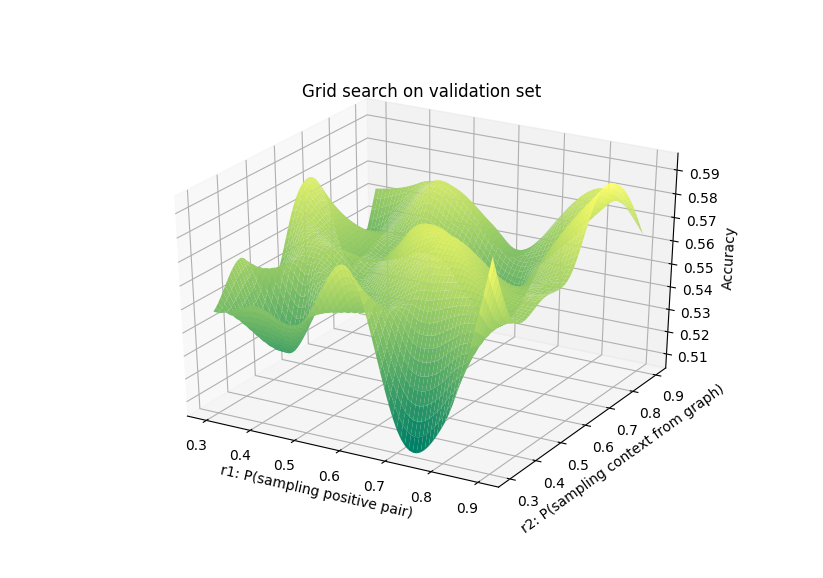

Text(0.5,0.92,'Grid search on validation set')

In [87]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z, cmap='summer', rstride=1, cstride=1, alpha=None, antialiased=True)
ax.plot_surface(newX, newY, newZ, cmap='summer', rstride=1, cstride=1, alpha=None, antialiased=True)

ax.set_xlabel("r1: P(sampling positive pair)")
ax.set_ylabel("r2: P(sampling context from graph)")
ax.set_zlabel("Accuracy")
ax.set_title("Grid search on validation set")

<IPython.core.display.Javascript object>


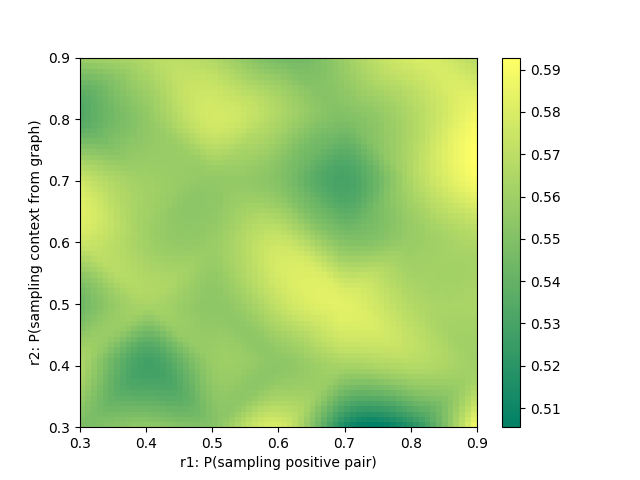

Text(0,0.5,'r2: P(sampling context from graph)')

In [88]:
%matplotlib notebook
# plt.pcolor(X, Y, Z, cmap='summer')
plt.pcolor(newX, newY, newZ, cmap='summer')
plt.colorbar()

plt.xlabel("r1: P(sampling positive pair)")
# plt.xlim(0, 1)
# plt.xticks(range(1, 21))

plt.ylabel("r2: P(sampling context from graph)")
# plt.yticks(range(20, 60, 10))

# plt.title("Heatmap of accuracy on validation set")

In [30]:
XX, YY = np.meshgrid(np.linspace(0.3, 0.9, 7), np.linspace(0.3, 0.9, 7))

In [31]:
XX

array([[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
       [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]])

In [32]:
YY

array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
       [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
       [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
       [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
       [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]])

In [33]:
Z

array([[0.548, 0.564, 0.544, 0.576, 0.574, 0.534, 0.562],
       [0.554, 0.528, 0.564, 0.56 , 0.56 , 0.556, 0.568],
       [0.552, 0.558, 0.554, 0.558, 0.556, 0.578, 0.564],
       [0.578, 0.554, 0.574, 0.574, 0.55 , 0.564, 0.544],
       [0.514, 0.564, 0.582, 0.55 , 0.53 , 0.55 , 0.56 ],
       [0.52 , 0.568, 0.566, 0.558, 0.566, 0.566, 0.58 ],
       [0.594, 0.56 , 0.564, 0.566, 0.592, 0.59 , 0.564]])